# Entraînement d'un modèle LSTM avec BERT pour la classification de texte

*Membres du groupe* :
- ADAM EZ-ZAHIR
- ACHRAF JEMALI
- ANGE-MARIE GOUNADON
- SOUROU ALFRED SOUDJI

# Introduction et grandes étapes

Dans ce projet, nous nous pencherons sur le développement d'un modèle de classification de texte en utilisant une approche plus avancée. Notre choix se porte sur l'intégration du modèle BERT (Bidirectional Encoder Representations from Transformers) dans une architecture LSTM (Long Short-Term Memory).


**Dataset**

Pour notre expérimentation, nous utiliserons le jeu de données AG_NEWS, une collection de titres d'articles de nouvelles accompagnés de descriptions provenant de diverses sources d'informations. Organisé en quatre catégories principales (Monde, Sports, Business et Science/Technologie), ce jeu de données offre un cadre propice à la classification de texte, permettant à notre modèle de prédire automatiquement la catégorie d'une nouvelle donnée.

Ci-dessous les grandes lignes de ce développement.

**Préparation de l'environnement**

Nous débuterons par la configuration de notre environnement de développement en important les bibliothèques nécessaires, notamment PyTorch pour la modélisation, Transformers pour l'intégration de BERT, et d'autres modules essentiels.

**Chargement des données**

Le jeu de données AG_NEWS sera chargé en utilisant les utilitaires de torchtext, simplifiant le processus de téléchargement et de prétraitement des données textuelles.

**Prétraitement du texte**

Nous aborderons les étapes de tokenisation et de construction de vocabulaire, tout en adaptant ces processus à l'intégration de BERT pour assurer une représentation adéquate des données.

**Construction du modèle LSTM avec BERT**

Définir la classe du modèle BertLSTMClassifier sera notre prochaine étape. Cette classe incorporera l'architecture LSTM, tirant parti des fonctionnalités de BERT pour une compréhension contextuelle plus profonde du texte.

**Entraînement du modèle**

Nous procéderons à l'entraînement du modèle en utilisant la technique de rétropropagation à travers le temps (BPTT). Nous ajusterons la fonction de perte et les paramètres d'optimisation pour garantir des performances optimales.

**Évaluation du modèle**

Enfin, nous évaluerons les performances du modèle en calculant la précision sur un ensemble de test. Cela nous permettra d'apprécier la capacité prédictive du modèle dans des conditions similaires à celles d'une application réelle.

Notre approche combinant LSTM et BERT vise à exploiter les avantages de chacun de ces modèles pour obtenir des résultats plus performants dans la classification de texte.



# Importation et Préparation

In [ ]:
!pip install portalocker>=2.0.0

In [ ]:
# Importation des modules nécessaires
from torchtext.datasets import AG_NEWS
import torch
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch import nn
from transformers import BertModel, BertTokenizer
import torch.optim as optim

# Crée un itérateur pour le jeu de données AG News avec l'ensemble d'entraînement
train_iter = iter(AG_NEWS(split='train'))

# Récupère le premier exemple du jeu de données
first_example = next(train_iter)

# Affiche le premier exemple
print(first_example)

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")


Ainsi nous pouvons avoir un apperçu d'un des éléments. Cet élément suggère que chaque ligne est un tuple de 2 éléments qui sont un label (ici "3") puis le texte ainsi labellisé

# Définition du Classificateur

Le code suivant définit une classe `BertLSTMClassifier` qui combine un modèle BERT pré-entraîné avec une couche LSTM pour la classification de texte. L'objectif est de capturer des représentations riches du texte avec BERT et de les traiter avec une couche LSTM pour effectuer la classification. Les paramètres de BERT sont figés pour conserver les poids pré-entraînés. La méthode `forward` spécifie le flux de données à travers le modèle lors de la propagation avant. Le modèle est conçu pour la tâche de classification de textes, en utilisant le jeu de données AG News comme exemple.

In [ ]:
# Définition d'un classificateur LSTM avec BERT
class BertLSTMClassifier(nn.Module):
    def __init__(self, hidden_dim, num_classes, bert_model_name='bert-base-uncased'):
        super(BertLSTMClassifier, self).__init__()

        # Initialisation du modèle BERT pré-entraîné
        self.bert = BertModel.from_pretrained(bert_model_name)

        # Couche LSTM prenant la sortie de BERT
        self.lstm = nn.LSTM(self.bert.config.hidden_size, hidden_dim, batch_first=True)

        # Couche entièrement connectée pour la classification
        self.fc = nn.Linear(hidden_dim, num_classes)

        # Désactivation de l'apprentissage pour les paramètres de BERT
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Exécution de BERT sur les données d'entrée (avec la désactivation des gradients)
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Passe la sortie de BERT à travers la couche LSTM
        lstm_out, _ = self.lstm(bert_output.last_hidden_state)


        # Sélectionne la dernière sortie de la séquence LSTM
        final_out = lstm_out[:, -1, :]

        # Passe la sortie finale à travers la couche entièrement connectée pour la classification
        return self.fc(final_out)

# Utilisation de l'itérateur pour obtenir un exemple du jeu de données AG News
next(iter(train_iter))

(3,
 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.')

Dans une architecture combinant BERT et LSTM pour la classification de texte, il n'est pas vraiment nécessaire d'ajouter une couche d'embedding supplémentaire. Cela est dû au fait que BERT (qui est un modèle d'encodeur) incorpore déjà chaque token en un vecteur dense lors de la phase d'encodage. Par conséquent, l'ajout d'une couche d'embedding supplémentaire pourrait introduire de la redondance et augmenter la complexité du modèle sans apporter de bénéfice significatif.

Dans l'architecture que nous proposons, l'objectif est d'utiliser BERT pour capturer les représentations contextuelles des tokens, puis d'alimenter ces représentations dans une couche LSTM pour capturer les dépendances séquentielles dans le texte. C'est pourquoi dans ce cas, nous utilisons directement la sortie de BERT sans ajout d'une couche d'embedding supplémentaire.

# Exploration sommaire de la donnée

Avant d'aller plus loin, nous faisons une petite exploration du jeu de données à présent

In [ ]:
!pip install wordcloud

In [ ]:
import nltk
from wordcloud import WordCloud, STOPWORDS
nltk.download('wordnet')
nltk.download('stopwords')
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Télécharge les jeux de données d'entraînement et de test AG News
train_iter, test_iter = AG_NEWS()

Ayant remarqué la fréquente occurence des caractères `\\` et `\` dans les textes, nous réalisons ci-dessous le petit traitement qui consiste à les supprimer des phrases. Cela pourrait éventuellement améliorer ne serait-ce que légèrement nos la compréhension des textes. Ou au moins, ne pas les altérer. Ce traitement est appliqué à la fois au jeu de données d'entrainement et au jeu de données de test.

D'un autre côté, nous supprimons les stopwords qui peuvent des fois être du bruit dans les phrases. En effet, leur présence ne peut pas être spécifique à un domaine particulier. Ainsi, leur suppression ne devrait point altérer la compréhension des textes.

In [ ]:
def clean_text(text):
    # Définition des stopwords de la langue anglaise
    stopw = set(stopwords.words('english'))

    # Supprimer les caractères spécifiques
    text_ = re.sub(r'[\\\"-]', ' ', text)

    # Supprimer les stopwords
    clean_text = []
    for word in text_.split(' '):
        if word.lower() not in stopw:
            clean_text.append(word)

    # Retourner le texte nettoyé
    return ' '.join(clean_text)


# Itérateur pour parcourir les exemples et appliquer la fonction de nettoyage
for sample in train_iter:
    text = sample[1]
    text = clean_text(text)

# Faire de même pour test_iter
for sample in test_iter:
    text = sample[1]
    text = clean_text(text)


In [ ]:
train_X, train_y = [text for text, _ in train_iter], [label for _, label in train_iter]
print(f"Le dataset d'entrainement a pour taille {len(train_y)}")

test_X, test_y = [text for text, _ in test_iter], [label for _, label in test_iter]
print(f"Le dataset de test comporte {len(test_y)} éléments")

Le dataset d'entrainement a pour taille 120000
Le dataset de test comporte 7600 éléments


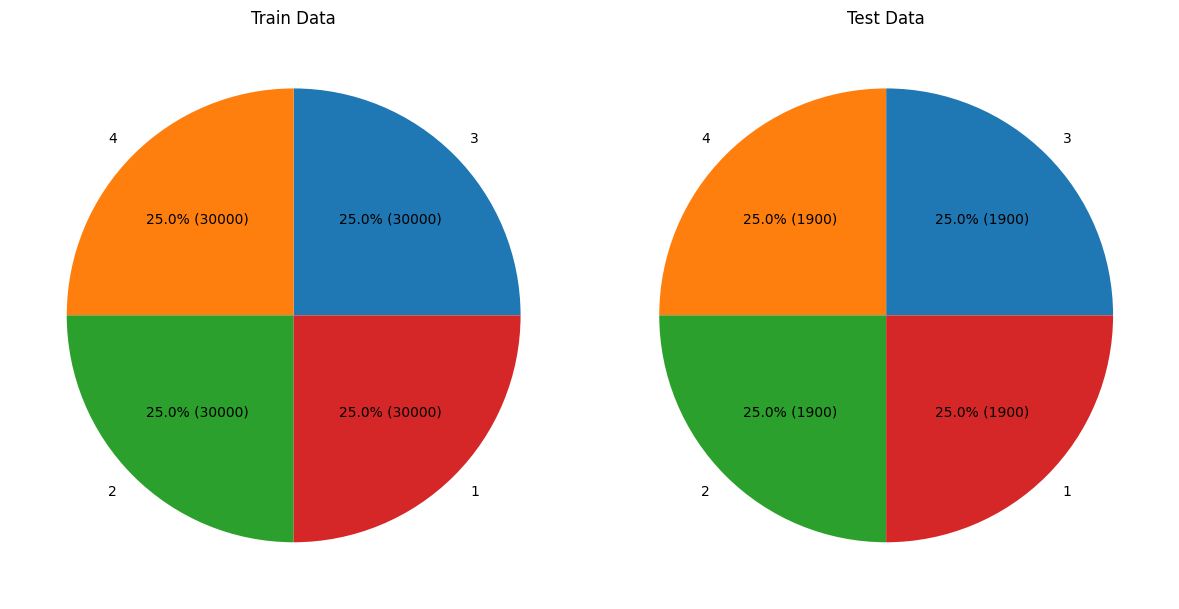

In [ ]:
import matplotlib.pyplot as plt

# Fonction pour compter les occurrences de chaque label dans les données
def count_labels(data_iter):
    label_counts = {}
    total_examples = 0

    for label, _ in data_iter:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1
        total_examples += 1

    return label_counts, total_examples


# Compter les occurrences de chaque label dans les données d'entraînement
train_label_counts, train_total_examples = count_labels(train_iter)

# Compter les occurrences de chaque label dans les données de test
test_label_counts, test_total_examples = count_labels(test_iter)

# Créer une figure avec deux sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Diagramme circulaire pour les données d'entraînement
axs[0].pie(train_label_counts.values(), labels=train_label_counts.keys(), autopct=lambda pct: f'{pct:.1f}% ({int(pct/100*train_total_examples)})')
axs[0].set_title('Train Data')

# Diagramme circulaire pour les données de test
axs[1].pie(test_label_counts.values(), labels=test_label_counts.keys(), autopct=lambda pct: f'{pct:.1f}% ({int(pct/100*test_total_examples)})')
axs[1].set_title('Test Data')

# Afficher la figure
plt.tight_layout()
plt.show()

On peut constater que le dataset d'entrainement est composé 120000 lignes de données qui sont équitablement réparties entre les 4 catégories(soit 30000 lignes pour chaque label). De même, les 7600 lignes du jeu de données de test sont équitablement réparties entre ces mêmes 4 catégories.

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


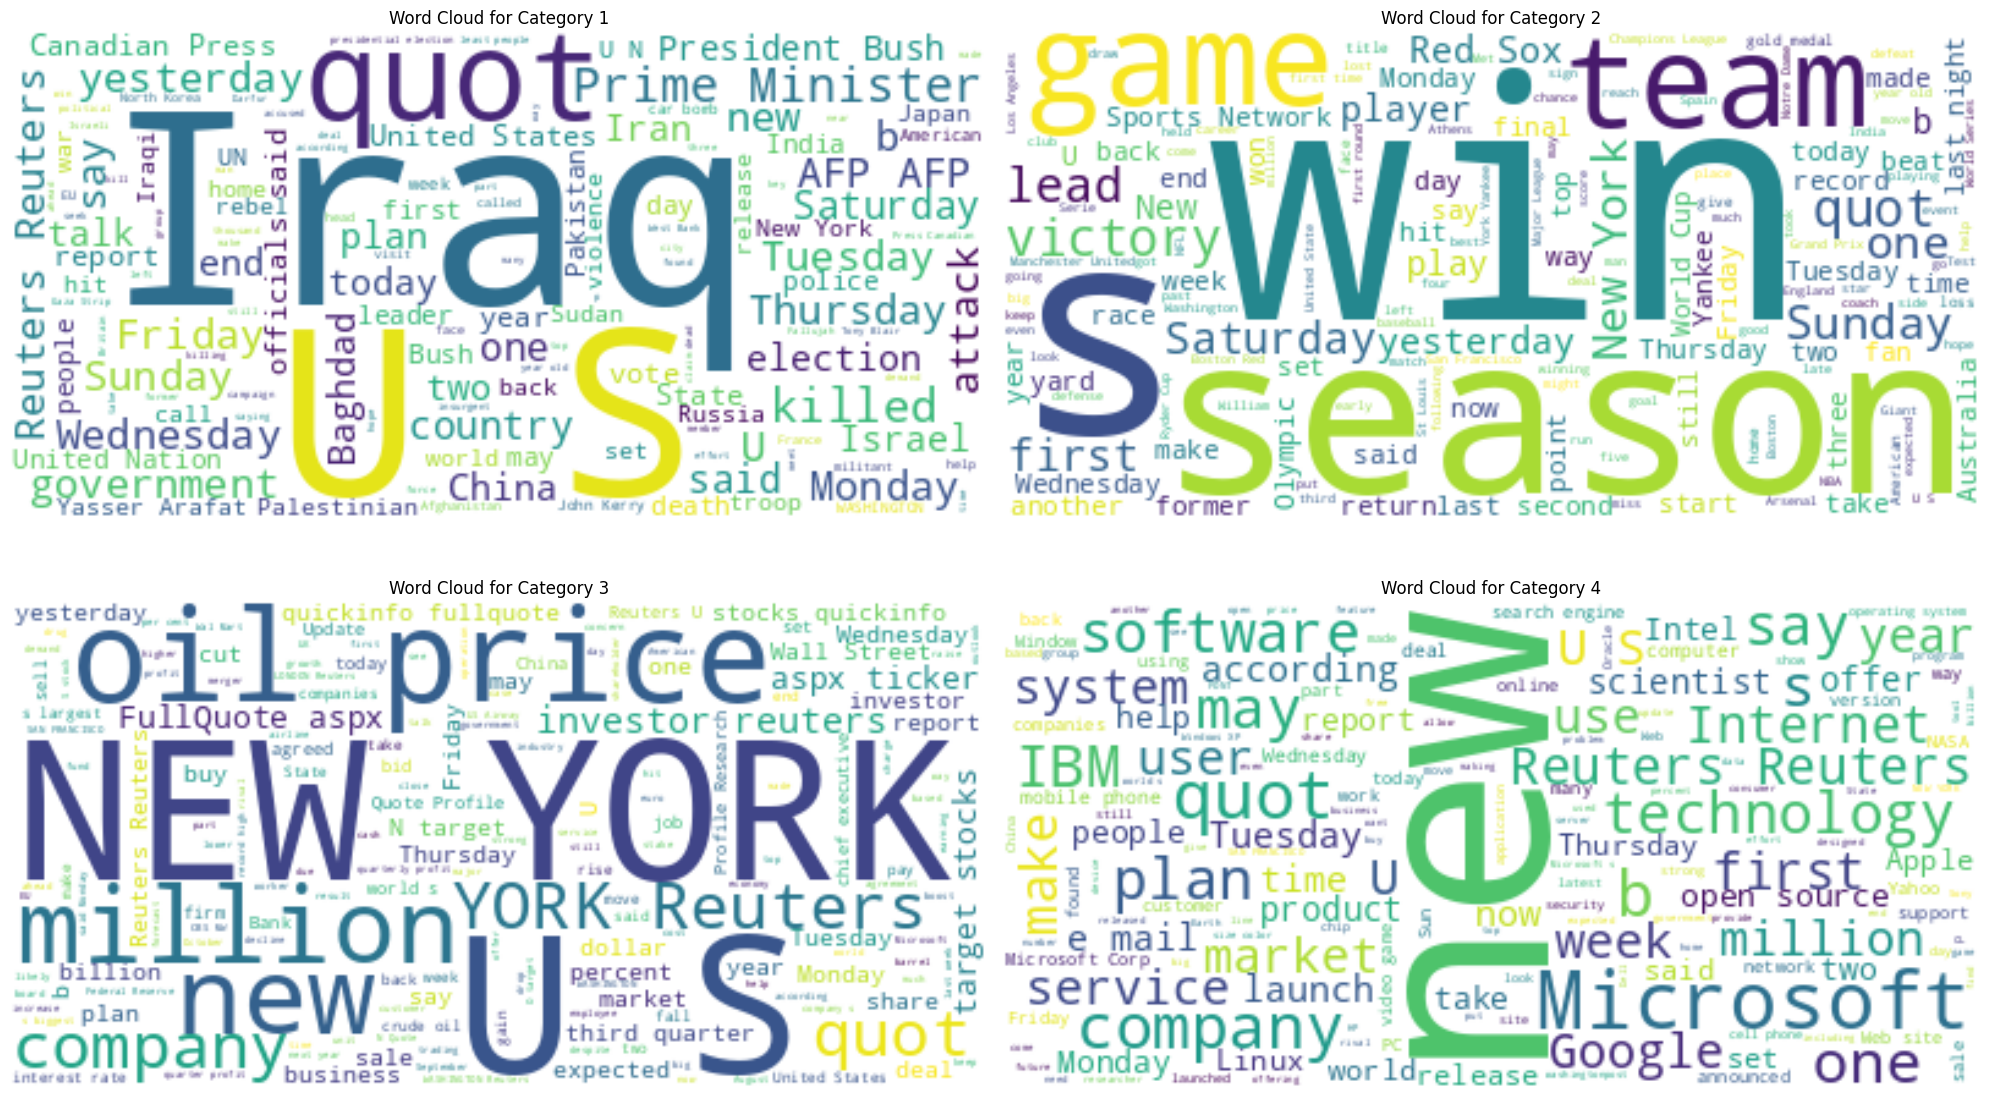

In [ ]:
import nltk
from wordcloud import WordCloud, STOPWORDS
nltk.download('wordnet')
nltk.download('stopwords')
import matplotlib.pyplot as plt

# Définir les stopwords communs
stopwordset = set(STOPWORDS)
morestop = {'lt','gt', 'href', 'HREF', 'hi', 'AP', "will"}
stopwordset = stopwordset.union(morestop)

# Parcourir chaque catégorie et générer un nuage de mots
fig, axs = plt.subplots(2, 2, figsize=(20, 12))  # Crée une figure avec 2 lignes et 2 colonnes pour chaque catégorie
for category in range(1, 5):
    # Filtrer les données pour la catégorie actuelle
    category_data = [(label, text) for label, text in train_iter if label == category]

    # Générer le nuage de mots pour la catégorie actuelle
    ax = axs[(category - 1) // 2][(category - 1) % 2]  # Sélectionne le sous-graphique correspondant à la catégorie
    wordcloud = WordCloud(max_words=500, background_color="white", stopwords=stopwordset).generate(' '.join(text for _, text in category_data))

    # Afficher le nuage de mots
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Word Cloud for Category {category}")
    ax.axis("off")

plt.tight_layout()
plt.show()


L'analyse des **quatre nuages de mots** permet de ressortir :

1. **Nuage de mots pour la catégorie 1 (World News)** :
   - Les termes clés incluent "Iraq", "President" "Prime Minister", "government", "election", "killed", "political", "current", et "US", "China", "Press".

2. **Nuage de mots pour la catégorie 2 (Sport News)** :
   - Les termes clés incluent "swin", "team", "game", "season", "win", "hit", "first", "final" et "run".


3. **Nuage de mots pour la catégorie 3 (Business News)** :
   - Les termes clés incluent "oil price", "New York", "company", "economic", "financial", "investor", "reuter", "third quarter", "stocks", "million", "sale" et "market".

4. **Nuage de mots pour la catégorie 4 (Scientific/Technologies News)** :
   - Les termes clés incluent "Microsoft", "technology", "company", "innovation", "internet", "market", "service", "software", "IBM", "e mail", "linux", "apple"  et "digital".

On constate bien que chaque catégorie est bien associée à un terme particulier autour duquel les mots ou expressions tournent. Cependant, on remarque aussi que certaines catégories ont quand même des mots en communs. Les catégories 3 et 4 se ressemblent donc relativement un peu sur certains mots. On retrouve en effet au niveau des 2, des termes comme : "market", "company". D'un autre côté, les termes "Reuter", "US" sont quasiment présents dans chaque section.

# Entrainement du modèle

Le code suivant que nous avons rédigé a pour objectif l'utilisation du modèle BERT pour la classification de texte sur le jeu de données AG News. Il configure l'environnement GPU si disponible, télécharge les données d'entraînement et de test AG News, utilise le tokenizer BERT pour traiter les textes, et crée des DataLoader pour l'entraînement et le test avec un batch_size de 8. L'objectif global est de préparer les données dans un format compatible avec BERT et de créer des DataLoader pour faciliter l'entraînement d'un modèle de classification de texte avec BERT

In [ ]:
# Vérifie la disponibilité de GPU et utilise CUDA s'il est disponible, sinon utilise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialise le tokenizer BERT avec le modèle 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Fonction pour regrouper un batch de données pour l'entraînement avec BERT
def collate_batch_bert(batch):
    # Récupère les textes et les étiquettes du batch
    texts = [x[1] for x in batch]
    labels = torch.tensor([x[0]-1 for x in batch], dtype=torch.long)  # Ajuste les étiquettes de 1 à n_classes

    # Tokenisation des textes avec BERT, avec gestion du padding et troncature
    encoding = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    input_ids = encoding['input_ids']  # Identifiants d'entrée BERT
    attention_mask = encoding['attention_mask']  # Masque d'attention pour les séquences

    # Retourne les étiquettes et les données tokenisées
    return labels.to(device), input_ids.to(device), attention_mask.to(device)

# Crée des DataLoader pour l'entraînement et le test avec le batch_size de 8
train_loader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch_bert)
test_loader = DataLoader(test_iter, batch_size=8, shuffle=False, collate_fn=collate_batch_bert)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Nous avons configuré le modèle pour la classification de texte en utilisant la classe BertLSTMClassifier. Nous avons définit les dimensions pour l'embedding, la couche cachée, et le nombre de classes. Ensuite, Nous avons instancié un objet de cette classe avec les dimensions spécifiées. Enfin, Nous avons définit une fonction de perte (CrossEntropyLoss) adaptée à la classification multiclasse, et configuré un optimiseur Adam avec un taux d'apprentissage de 0.001 pour l'entraînement du modèle. L'objectif global est de préparer le modèle pour l'entraînement en spécifiant ses caractéristiques et les paramètres d'entraînement.






In [ ]:
# Définition des dimensions pour l'embedding, la couche cachée, et le nombre de classes
embed_dim = 64
hidden_dim = 128
num_classes = 4

# Instanciation d'un objet de la classe BertLSTMClassifier avec les dimensions spécifiées
model = BertLSTMClassifier(hidden_dim, num_classes).to(device)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()  # Fonction de perte pour la classification multiclasse
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimiseur Adam avec un taux d'apprentissage de 0.001

Ce code implémente une boucle d'entraînement sur plusieurs époques pour un modèle de classification de texte utilisant BERT et LSTM. Il effectue la propagation avant, calcule la perte, effectue la rétropropagation, et met à jour les poids du modèle à chaque itération sur les batches d'entraînement. La précision d'entraînement et de test est surveillée et affichée après chaque époque. L'objectif global est d'entraîner le modèle et d'évaluer ses performances sur les données de test.

In [ ]:
from tqdm import tqdm

# Boucle d'entraînement sur 5 époques
for epoch in range(5):
    model.train()  # Met le modèle en mode d'entraînement
    total_loss = 0
    num_batches = 0
    correct_preds = 0  # Nombre de prédictions correctes
    total_preds = 0  # Nombre total de prédictions

    # Barre de progression pour l'époque en cours
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}')

    model.train()  # Met à nouveau le modèle en mode d'entraînement (au cas où)

    # Boucle sur les batches d'entraînement
    for labels, input_ids, attention_mask in progress_bar:
        num_batches += 1
        labels = labels.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        optimizer.zero_grad()  # Réinitialise les gradients
        output = model(input_ids, attention_mask)  # Propagation avant

        loss = criterion(output, labels)  # Calcul de la perte
        loss.backward()  # Rétropropagation
        optimizer.step()  # Mise à jour des poids du modèle

        total_loss += loss.item()  # Accumulation de la perte

        _, predicted_labels = torch.max(output, 1)  # Sélection des prédictions

        correct_preds += (predicted_labels == labels).sum().item()  # Calcul des prédictions correctes
        total_preds += labels.size(0)  # Accumulation du nombre total de prédictions

        # Mise à jour de la barre de progression
        progress_bar.set_postfix({
            'Train Loss': loss.item(),
            'Train Acc': 100. * correct_preds / total_preds
        })

    # Calcul de la perte moyenne et de la précision d'entraînement
    train_loss = total_loss / num_batches
    train_accuracy = 100. * correct_preds / total_preds

    # Mise en mode évaluation pour l'évaluation sur les données de test
    model.eval()

    correct_preds = 0
    total_preds = 0

    # Boucle sur les batches de test
    for labels, input_ids, attention_mask in test_loader:
        labels = labels.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        output = model(input_ids, attention_mask)  # Propagation avant sur les données de test

        _, predicted_labels = torch.max(output, 1)  # Sélection des prédictions

        correct_preds += (predicted_labels == labels).sum().item()  # Calcul des prédictions correctes
        total_preds += labels.size(0)  # Accumulation du nombre total de prédictions

    # Calcul de la précision sur les données de test
    test_accuracy = 100 * correct_preds / total_preds

    # Affichage des résultats de l'époque
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}%')


Epoch 1: 15000it [12:19, 20.28it/s, Train Loss=0.00497, Train Acc=90.4]


Epoch 1, Train Loss: 0.2761, Train Accuracy: 90.42, Test Accuracy: 91.14%


Epoch 2: 15000it [12:11, 20.50it/s, Train Loss=0.000842, Train Acc=92.4]


Epoch 2, Train Loss: 0.2150, Train Accuracy: 92.40, Test Accuracy: 91.68%


Epoch 3: 15000it [12:12, 20.48it/s, Train Loss=0.00163, Train Acc=93]


Epoch 3, Train Loss: 0.1985, Train Accuracy: 93.03, Test Accuracy: 92.20%


Epoch 4: 15000it [12:10, 20.54it/s, Train Loss=0.0022, Train Acc=93.5]


Epoch 4, Train Loss: 0.1840, Train Accuracy: 93.54, Test Accuracy: 92.36%


Epoch 5: 15000it [12:08, 20.59it/s, Train Loss=0.00249, Train Acc=93.9]


Epoch 5, Train Loss: 0.1722, Train Accuracy: 93.93, Test Accuracy: 92.93%


# Evaluation du modèle

Nous passons à présnet à l'évaluation de notre modèle

In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Liste pour stocker les prédictions et les vraies étiquettes
all_predictions = []
all_labels = []

# Boucle sur les batches de test
for labels, input_ids, attention_mask in test_loader:
    labels = labels.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    output = model(input_ids, attention_mask)  # Propagation avant sur les données de test

    _, predicted_labels = torch.max(output, 1)  # Sélection des prédictions

    all_predictions.extend(predicted_labels.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Affichage de la matrice de confusion
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[1753   39   62   46]
 [   8 1882    8    2]
 [  49   11 1712  128]
 [  35   13  136 1716]]


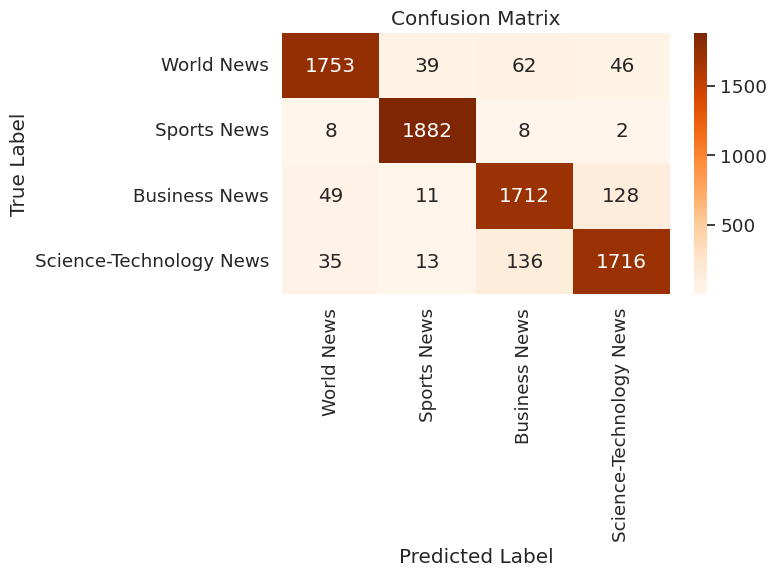

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Définition du dictionnaire des étiquettes
ag_news_label = {
    0: "World News",
    1: "Sports News",
    2: "Business News",
    3: "Science-Technology News"
}

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Création de la figure et du plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=ag_news_label.values(), yticklabels=ag_news_label.values(), cbar=True)

# Correction de l'alignement des labels sur l'axe des ordonnées
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

# Ajout des titres et des étiquettes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Affichage du plot
plt.tight_layout()
plt.show()


In [ ]:
# Affichage du rapport de classification
class_names = [str(i) for i in range(num_classes)]  # Noms de classe pour l'affichage
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1900
           1       0.97      0.99      0.98      1900
           2       0.89      0.90      0.90      1900
           3       0.91      0.90      0.91      1900

    accuracy                           0.93      7600
   macro avg       0.93      0.93      0.93      7600
weighted avg       0.93      0.93      0.93      7600



 *  Dans l'ordre, on peut remarquer que le label le mieux prédit est le label `Sport News` avec sa précision de 97% (1882 bonnes prédictions sur 1990 présents). Cela est peut-être dû au fait que finalement, les textes de ce label sont ceux qui sont les plus éloignés (sémantiquement ou au niveau du vocabulaire)  des autres textes. Dans l'ordre, viennent ensuite les catégories `World News` (95%) , `Science-Technology News`(91%) et enfin `Business News`(90%). Ces 2 derniers labels étant ceux qui sont les plus confondus entre eux. Ainsi, 128 textes du label "Business New" ont été prédit comme des "Science-Technology News". C'est un peu plus de 68% des mauvaises prédictions. De même on remarque que dans l'autre sens, plus de 73% (136) des mauvaises prédictions du label "Science-Technology News" ont été attribué au label "Business New". Ce qui probablement est dû à la petite ressemblance sémantique entre les vocabulaires de ces deux labels constatée plus haut.


*   La précision est toute fois fois sur les 4 labels de façon globale portant notre modèle à une `accuracy` globale de 93% environ.


# Conclusion et apprentissage

Dans ce projet, nous avons développé un modèle de classification de texte en combinant les architectures LSTM et BERT. En utilisant le jeu de données AG_NEWS, nous avons réussi à prédire automatiquement la catégorie de différents articles de nouvelles, avec une précision globale d'environ 93%. Cette bonne performance globale a été obtenu grâce au prétraitement du texte notamment la tokenisation mais aussi à l'utilisation du modèle BERT pour une meilleure compréhension contextuelle du texte. Nous avons constaté que notre modèle avait des performances particulièrement élevées pour prédire les articles de sport, tandis que les catégories de nouvelles liées aux affaires et à la technologie étaient parfois confondues(ces constats sont certainement le fruit d'une sémantique/d'un vocabulaire soit relativement proche ou éloigné).
Ce projet nous a permis de comprendre l'importance et l'efficacité de l'utilisation de modèles pré-entraînés tels que BERT pour améliorer les performances des modèles de classification de texte. Nous avons également appris à intégrer ces modèles pré-entraînés dans des architectures plus complexes, telles que les réseaux LSTM, pour tirer parti de leurs avantages respectifs. En résumé, ce projet nous a donné un aperçu des techniques avancées de traitement automatique du langage naturel et de classification de texte, tout en mettant en évidence les avantages et les défis de l'intégration de modèles pré-entraînés dans des architectures plus complexes.